# Baseline Model

In [5]:
import kagglehub

path = kagglehub.dataset_download("ayushmandatta1/deepdetect-2025")
print("Path to dataset files:", path)

Path to dataset files: /Users/zhihongmtl/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1


In [ ]:
import os

train_dir = os.path.join(path, "ddata", "train")
test_dir  = os.path.join(path, "ddata", "test")
print("Train:", train_dir)
print("Test:", test_dir)
print("Train subdirs:", os.listdir(train_dir))
print("Test subdirs:", os.listdir(test_dir))

# check：
val_dir = test_dir
print("Validation:", val_dir)

Train: /Users/zhihongmtl/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/train
Test: /Users/zhihongmtl/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test
Train subdirs: ['real', 'fake']
Test subdirs: ['real', 'fake']


Define Dataset and DataLoader

In [4]:
import os, sys

# notebooks 的上一级就是项目根目录
project_root = os.path.abspath("..")
sys.path.append(os.path.join(project_root, "src"))

from dataset import RealFakeDataset, get_default_transform

In [ ]:
from torch.utils.data import DataLoader

# 使用 src/dataset.py 里的默认 transform
transform = get_default_transform(224)

# 构建 train / val 数据集和 DataLoader
train_dataset = RealFakeDataset(train_dir, transform=transform)
val_dataset   = RealFakeDataset(test_dir,   transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

print(len(train_dataset), len(val_dataset))

90409 21776


setup device + loss function

In [4]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

device = "cuda" if torch.cuda.is_available() else (
         "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

criterion = nn.CrossEntropyLoss()

Using device: cuda


Training

In [5]:
num_runs = 1       # 先测试 1 次
num_epochs = 3     # 先训练 3 个 epoch 看效果

for run in range(num_runs):
    print(f"\n========== Run {run+1}/{num_runs} ==========")

    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(2048, 2)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for step, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (step + 1) % 200 == 0:
                print(f"Run {run+1} | Epoch {epoch+1}/{num_epochs} "
                      f"| Step {step+1}/{len(train_loader)} "
                      f"| Loss: {running_loss / (step+1):.4f}")

        # ----- Validation -----
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)

                total += labels.size(0)
                correct += (preds == labels).sum().item()

        val_acc = correct / total

        print(f"[Run {run+1}] Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {running_loss:.4f}  "
              f"Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            save_name = f"resnet50_baseline_run{run+1}_best.pth"
            torch.save(model.state_dict(), save_name)
            print(f"Saved new best model for run {run+1}: {save_name}")



========== Run 1/1 ==========
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]


Run 1 | Epoch 1/3 | Step 200/2826 | Loss: 0.2454
Run 1 | Epoch 1/3 | Step 400/2826 | Loss: 0.1815
Run 1 | Epoch 1/3 | Step 600/2826 | Loss: 0.1491
Run 1 | Epoch 1/3 | Step 800/2826 | Loss: 0.1296
Run 1 | Epoch 1/3 | Step 1000/2826 | Loss: 0.1141
Run 1 | Epoch 1/3 | Step 1200/2826 | Loss: 0.1028
Run 1 | Epoch 1/3 | Step 1400/2826 | Loss: 0.0942
Run 1 | Epoch 1/3 | Step 1600/2826 | Loss: 0.0862
Run 1 | Epoch 1/3 | Step 1800/2826 | Loss: 0.0811
Run 1 | Epoch 1/3 | Step 2000/2826 | Loss: 0.0771
Run 1 | Epoch 1/3 | Step 2200/2826 | Loss: 0.0737
Run 1 | Epoch 1/3 | Step 2400/2826 | Loss: 0.0702
Run 1 | Epoch 1/3 | Step 2600/2826 | Loss: 0.0666
Run 1 | Epoch 1/3 | Step 2800/2826 | Loss: 0.0638
[Run 1] Epoch [1/3] Train Loss: 179.1242  Val Acc: 0.7000
Saved new best model for run 1: resnet50_baseline_run1_best.pth
Run 1 | Epoch 2/3 | Step 200/2826 | Loss: 0.0207
Run 1 | Epoch 2/3 | Step 400/2826 | Loss: 0.0231
Run 1 | Epoch 2/3 | Step 600/2826 | Loss: 0.0228
Run 1 | Epoch 2/3 | Step 800/2826 |

Define load_trained_model and predict_image

In [6]:
from torchvision import transforms
from PIL import Image

# 和训练时一样的 transform
infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

class_names = ["real", "fake"]  # 0 = real, 1 = fake

def load_trained_model(weight_path):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(2048, 2)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def predict_image(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    x = infer_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)                    # (1,2)
        probs = torch.softmax(logits, dim=1)
        prob_real = probs[0, 0].item()
        prob_fake = probs[0, 1].item()
        pred_idx = probs.argmax(dim=1).item()
        pred_label = class_names[pred_idx]

    print(f"Image: {image_path}")
    print(f"Predicted: {pred_label}")
    print(f"  P(real) = {prob_real:.4f}")
    print(f"  P(fake) = {prob_fake:.4f}")

    return pred_label, prob_real, prob_fake

take one REAL and FAKE to test

In [7]:
# 1. 先从 test 集中各拿一张图片
real_dir = os.path.join(test_dir, "real")
fake_dir = os.path.join(test_dir, "fake")

real_files = os.listdir(real_dir)
fake_files = os.listdir(fake_dir)

real_example_path = os.path.join(real_dir, real_files[0])
fake_example_path = os.path.join(fake_dir, fake_files[0])

print("Example real:", real_example_path)
print("Example fake:", fake_example_path)

# 2. 加载训练好的模型
model = load_trained_model("resnet50_baseline_run1_best.pth")

# 3. 预测一张真实图
print("\n===== REAL IMAGE =====")
predict_image(model, real_example_path, device)

# 4. 预测一张 AI 图
print("\n===== FAKE IMAGE =====")
predict_image(model, fake_example_path, device)


Example real: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/real/real_052254.png
Example fake: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043069.jpg

===== REAL IMAGE =====
Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/real/real_052254.png
Predicted: real
  P(real) = 0.9448
  P(fake) = 0.0552

===== FAKE IMAGE =====
Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043069.jpg
Predicted: real
  P(real) = 0.8634
  P(fake) = 0.1366


('real', 0.8634066581726074, 0.13659335672855377)

***Confusion Matrix***

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [9]:
def eval_on_loader(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            preds = logits.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [10]:
y_true, y_pred = eval_on_loader(model, val_loader, device)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

y_true shape: (21776,)
y_pred shape: (21776,)


***Confusion Matrix and print the report***

Confusion matrix:
 [[8806 2571]
 [ 645 9754]]


<Figure size 500x500 with 0 Axes>

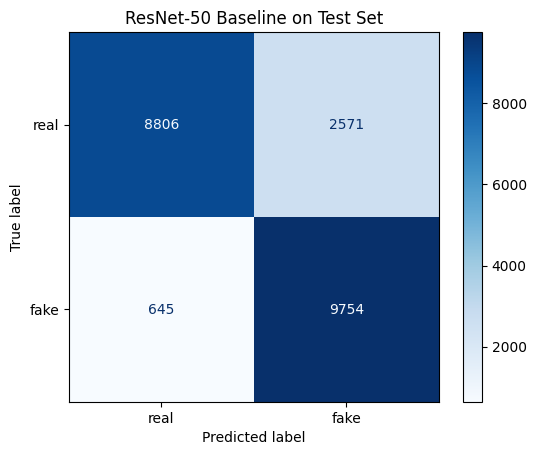


Classification report:
              precision    recall  f1-score   support

        real     0.9318    0.7740    0.8456     11377
        fake     0.7914    0.9380    0.8585     10399

    accuracy                         0.8523     21776
   macro avg     0.8616    0.8560    0.8520     21776
weighted avg     0.8647    0.8523    0.8517     21776



In [11]:
class_names = ["real", "fake"]  # 0=real, 1=fake

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

plt.figure(figsize=(5, 5))
disp.plot(values_format="d", cmap="Blues")
plt.title("ResNet-50 Baseline on Test Set")
plt.show()

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

TP/TN/FP/FN

In [12]:
import random
import matplotlib.pyplot as plt

# 保证和前面保持一致
class_names = ["real", "fake"]  # 0=real, 1=fake

def collect_examples(model, dataset, device, max_per_group=4):
    """
    从 dataset（这里用 val_dataset）中收集一些样例：
      - TP: fake -> fake
      - TN: real -> real
      - FP: real -> fake（错判成假）
      - FN: fake -> real（错判成真）
    """
    model.eval()
    examples = {
        "TN_real_correct": [],
        "TP_fake_correct": [],
        "FP_real_to_fake": [],
        "FN_fake_to_real": [],
    }

    # 打乱一下顺序
    indices = list(range(len(dataset.samples)))
    random.shuffle(indices)

    with torch.no_grad():
        for idx in indices:
            path, label = dataset.samples[idx]  # label: 0=real,1=fake
            img = Image.open(path).convert("RGB")

            # 模型预测
            x = infer_transform(img).unsqueeze(0).to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
            pred = probs.argmax()

            # 根据情况分类
            if label == 0 and pred == 0 and len(examples["TN_real_correct"]) < max_per_group:
                examples["TN_real_correct"].append((img, label, pred, probs, path))

            elif label == 1 and pred == 1 and len(examples["TP_fake_correct"]) < max_per_group:
                examples["TP_fake_correct"].append((img, label, pred, probs, path))

            elif label == 0 and pred == 1 and len(examples["FP_real_to_fake"]) < max_per_group:
                examples["FP_real_to_fake"].append((img, label, pred, probs, path))

            elif label == 1 and pred == 0 and len(examples["FN_fake_to_real"]) < max_per_group:
                examples["FN_fake_to_real"].append((img, label, pred, probs, path))

            # 四类都满了就停
            if all(len(v) >= max_per_group for v in examples.values()):
                break

    return examples

drawing function

In [13]:
import math

def show_examples(example_list, title):
    if len(example_list) == 0:
        print(f"{title}: no examples found.")
        return

    cols = min(4, len(example_list))
    rows = math.ceil(len(example_list) / cols)

    plt.figure(figsize=(4 * cols, 4 * rows))
    for i, (img, label, pred, probs, path) in enumerate(example_list):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"T: {class_names[label]}  P: {class_names[pred]}\n"
            f"P(fake)={probs[1]:.2f}"
        )
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Display

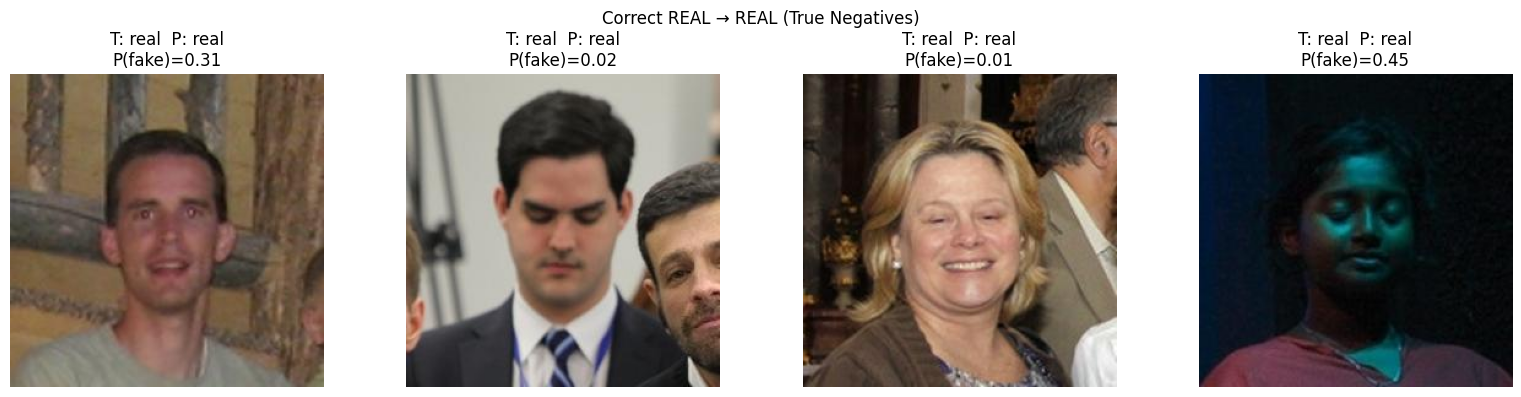

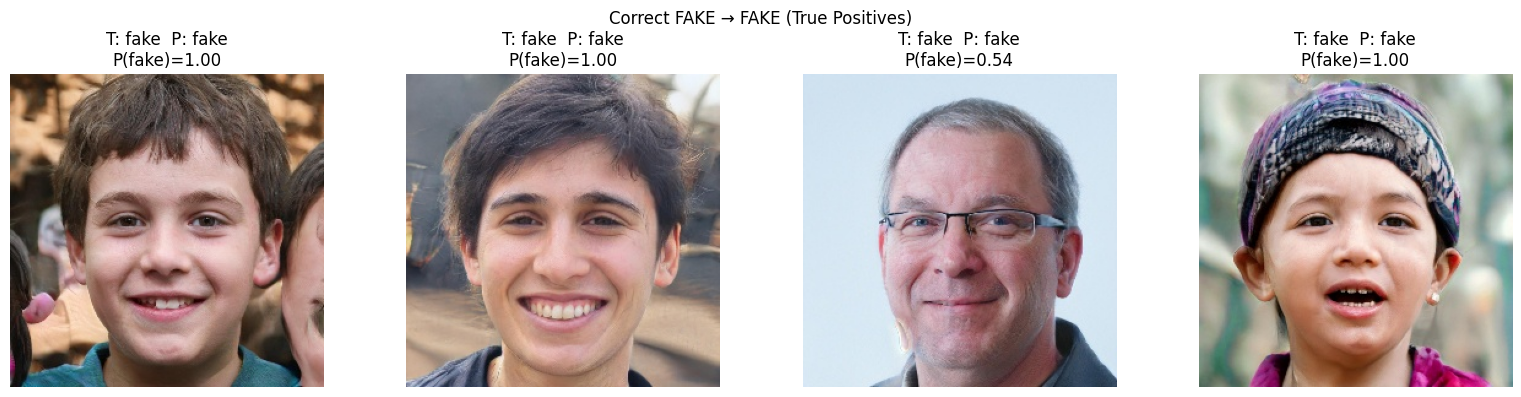

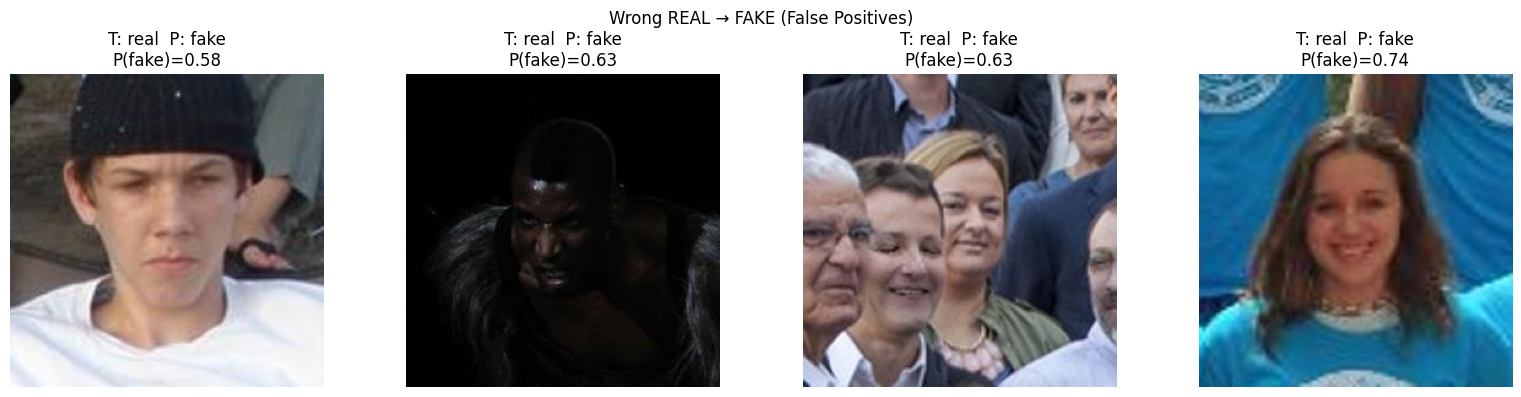

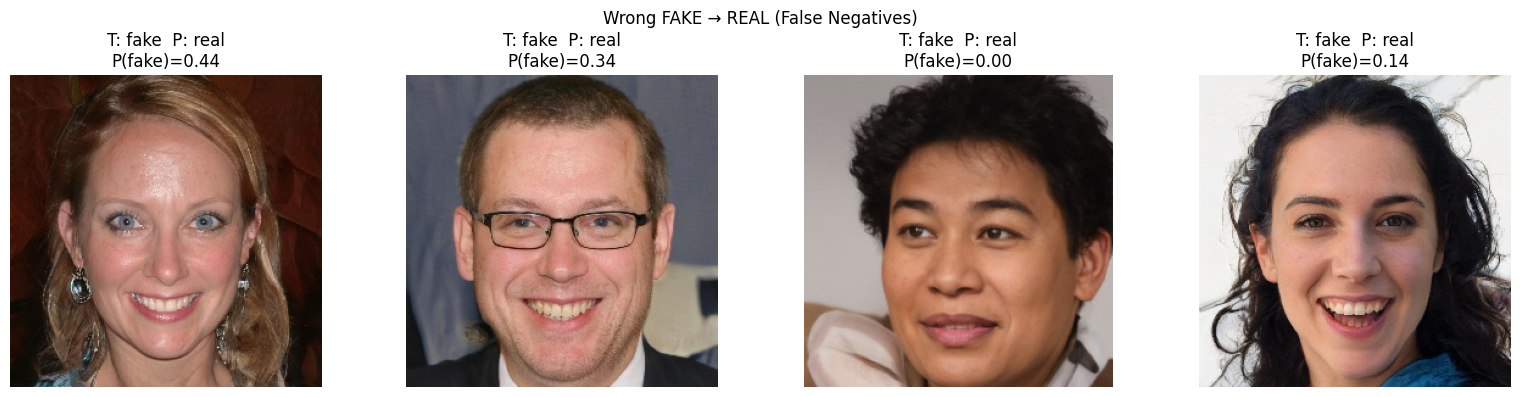

In [14]:
# 用 val_dataset 收集样例
examples = collect_examples(model, val_dataset, device, max_per_group=4)

# 画 4 组图：
show_examples(examples["TN_real_correct"], "Correct REAL → REAL (True Negatives)")
show_examples(examples["TP_fake_correct"], "Correct FAKE → FAKE (True Positives)")
show_examples(examples["FP_real_to_fake"], "Wrong REAL → FAKE (False Positives)")
show_examples(examples["FN_fake_to_real"], "Wrong FAKE → REAL (False Negatives)")


ROC + PR Curve Graph

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

def collect_scores(model, loader, device):
    model.eval()
    all_labels = []
    all_scores = []   # 存 P(fake)

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)

            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]  # 取 fake 类的概率

            all_labels.extend(labels.numpy())
            all_scores.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_scores)

# 用你已经加载好的 best 模型 + val_loader
y_true, y_score = collect_scores(model, val_loader, device)

print("y_true shape:", y_true.shape)
print("y_score shape:", y_score.shape)


y_true shape: (21776,)
y_score shape: (21776,)


Draw the graph

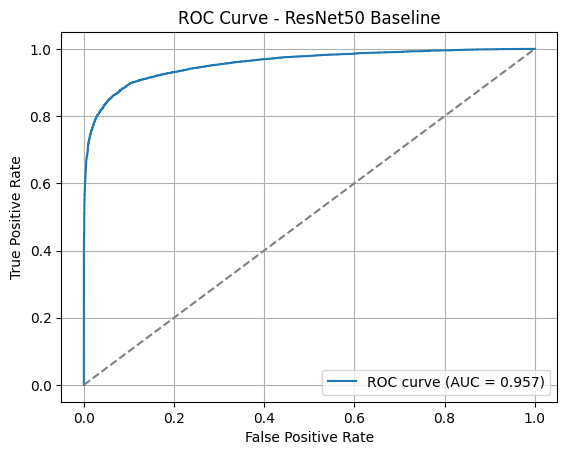

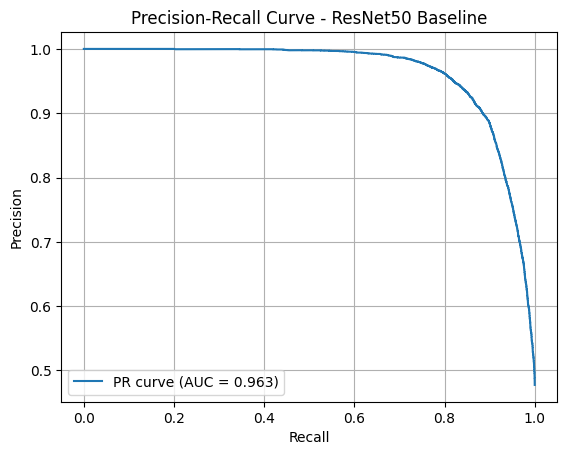

In [16]:
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet50 Baseline")
plt.legend()
plt.grid(True)
plt.show()

# PR curve
precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - ResNet50 Baseline")
plt.legend()
plt.grid(True)
plt.show()


P(fake) Distribution Histogram

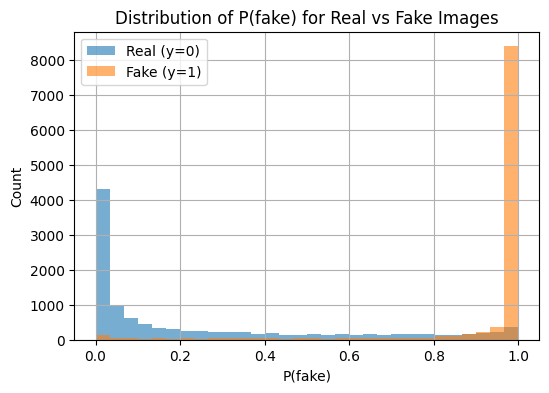

In [17]:
real_scores = y_score[y_true == 0]   # 真图的 P(fake)
fake_scores = y_score[y_true == 1]   # 假图的 P(fake)

plt.figure(figsize=(6, 4))
plt.hist(real_scores, bins=30, alpha=0.6, label="Real (y=0)")
plt.hist(fake_scores, bins=30, alpha=0.6, label="Fake (y=1)")
plt.xlabel("P(fake)")
plt.ylabel("Count")
plt.title("Distribution of P(fake) for Real vs Fake Images")
plt.legend()
plt.grid(True)
plt.show()

# Grad-CAM visualization of the baseline ResNet-50

1. Define the Grad-GAM

In [19]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model:  ResNet-50
        target_layer: 用来做 Grad-CAM 的卷积层
        """
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None   # forward 时的 feature map
        self.gradients = None     # backward 时的梯度

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            # grad_out 是一个 tuple，这里取第 0 个
            self.gradients = grad_out[0].detach()

        # 注册 hook
        self.fwd_handle = target_layer.register_forward_hook(forward_hook)
        self.bwd_handle = target_layer.register_backward_hook(backward_hook)

    def generate(self, x, class_idx=None):
        """
        x: 输入 tensor，形状 [1,3,224,224]
        class_idx: 针对哪一类做 Grad-CAM（0=real, 1=fake），
                   如果为 None，就用模型的预测类别。
        返回: 归一化后的 CAM，numpy 数组，范围 [0,1]，形状 [H,W]
        """
        self.model.zero_grad()
        output = self.model(x)   # [1, num_classes]

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        score = output[0, class_idx]
        score.backward()

        # 取这一张图对应的 feature & grad
        grads = self.gradients[0]    # [C, H, W]
        acts  = self.activations[0]  # [C, H, W]

        # Grad-CAM: 通道平均权重
        weights = grads.mean(dim=(1, 2))  # [C]

        # 加权求和得到初始 CAM
        cam = (weights[:, None, None] * acts).sum(dim=0)  # [H, W]
        cam = torch.relu(cam)

        # 归一化到 [0,1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        # 双线性插值到 224x224
        cam = cam.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
        cam = F.interpolate(cam, size=(224, 224),
                            mode="bilinear", align_corners=False)
        cam = cam[0, 0].cpu().numpy()        # [224,224]

        return cam


2. Define the visualization function

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# class_names = ["real", "fake"]

#  Initialize a Grad-CAM object, selecting the final block of ResNet-50 as the target_layer.
gradcam = GradCAM(model, model.layer4[-1])

def show_gradcam_for_image(image_path, model, device, class_idx=None, title=None):
    # 1. load the image
    img_pil = Image.open(image_path).convert("RGB")
    img_resized = img_pil.resize((224, 224))

    # 2. Perform the same preprocessing
    x = infer_transform(img_pil).unsqueeze(0).to(device)  # [1,3,224,224]

    # 3.  First run the prediction to obtain the probabilities and predicted categories.
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(probs))

    if class_idx is None:
        class_idx = pred_idx

    # 4. generate Grad-CAM for class_idx
    cam = gradcam.generate(x, class_idx=class_idx)  # [224,224]

    # 5. Overlay display
    img_np = np.array(img_resized) / 255.0

    plt.figure(figsize=(8, 4))

    # Left: Original image + predicted label
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis("off")
    base_title = f"Pred: {class_names[pred_idx]}  " \
                 f"P(real)={probs[0]:.2f}, P(fake)={probs[1]:.2f}"
    plt.title(title or base_title, fontsize=10)

    # Right: Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.imshow(cam, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title("Grad-CAM", fontsize=10)

    plt.tight_layout()
    plt.show()

    print(f"Image: {image_path}")
    print(f"Predicted: {class_names[pred_idx]}, probs={probs}")
    print(f"Grad-CAM class_idx = {class_idx} ({class_names[class_idx]})")


3. Run Grad-CAM on one or two real/fake images

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


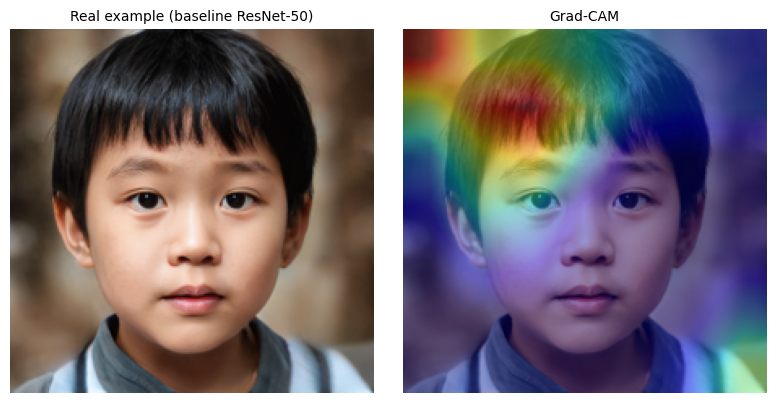

Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/real/real_052254.png
Predicted: real, probs=[0.94475764 0.05524237]
Grad-CAM class_idx = 0 (real)


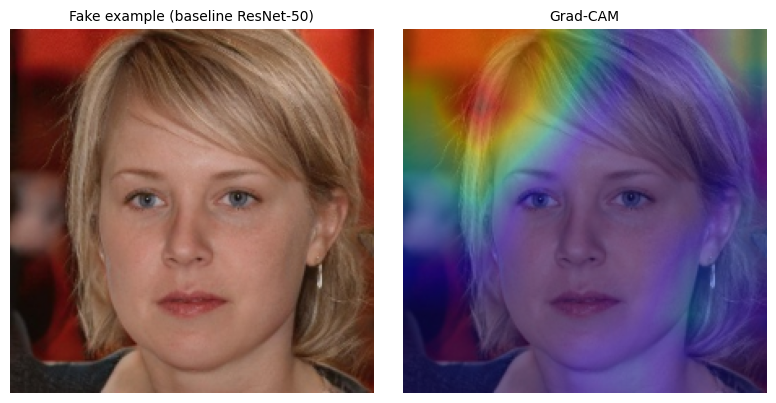

Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043069.jpg
Predicted: real, probs=[0.86340666 0.13659336]
Grad-CAM class_idx = 0 (real)


In [22]:
# Real Sample
show_gradcam_for_image(
    real_example_path,
    model,
    device,
    title="Real example (baseline ResNet-50)"
)

# Fake Sample
show_gradcam_for_image(
    fake_example_path,
    model,
    device,
    title="Fake example (baseline ResNet-50)"
)

# Baseline Failure Cases + Grad-CAM

Automatically identify false negative samples from val_dataset

In [24]:
import numpy as np
from PIL import Image

# 0=real, 1=fake
class_names = ["real", "fake"]

def find_false_negatives(model, dataset, device, max_samples=4):
    """
    找到 T: fake, P: real 的样本（False Negatives）
    返回列表，每个元素: (image_path, true_label, pred_label, probs)
    """
    model.eval()
    fn_examples = []

    with torch.no_grad():
        # RealFakeDataset 有 dataset.samples: [(path, label_int), ...]
        for path, label in dataset.samples:
            if label != 1:   # only check sample's label as fake
                continue

            img = Image.open(path).convert("RGB")
            x = infer_transform(img).unsqueeze(0).to(device)

            logits = model(x)
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
            pred = int(np.argmax(probs))

            # fake →real：FN
            if pred == 0:  # 0 = real
                fn_examples.append((path, label, pred, probs))

                if len(fn_examples) >= max_samples:
                    break

    return fn_examples

# find 4  FN sample
fn_examples = find_false_negatives(model, val_dataset, device, max_samples=4)
print(f"Found {len(fn_examples)} false negatives.")
for i, (path, label, pred, probs) in enumerate(fn_examples):
    print(f"{i+1}. {path}")
    print(f"   T={class_names[label]}, P={class_names[pred]}, P(fake)={probs[1]:.3f}")


Found 4 false negatives.
1. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043069.jpg
   T=fake, P=real, P(fake)=0.137
2. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043165.jpg
   T=fake, P=real, P(fake)=0.160
3. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_050894.jpg
   T=fake, P=real, P(fake)=0.261
4. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_050990.jpg
   T=fake, P=real, P(fake)=0.280


Batch Grad-CAM analysis of these FN samples (Failure Case Analysis Page)

FN 1: T=fake, P=real  P(fake)=0.14


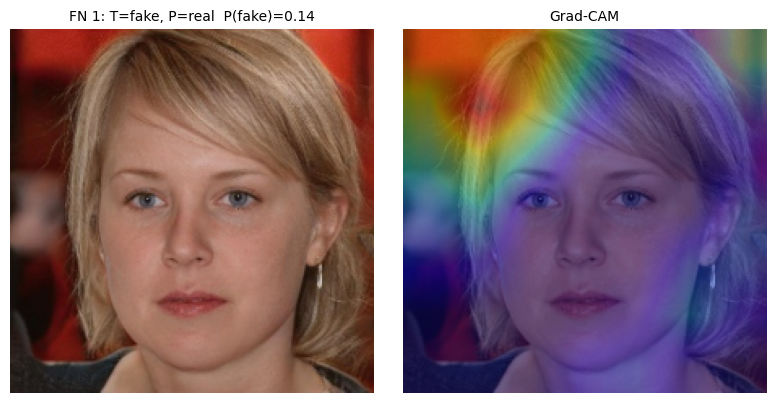

Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043069.jpg
Predicted: real, probs=[0.86340666 0.13659336]
Grad-CAM class_idx = 0 (real)
FN 2: T=fake, P=real  P(fake)=0.16


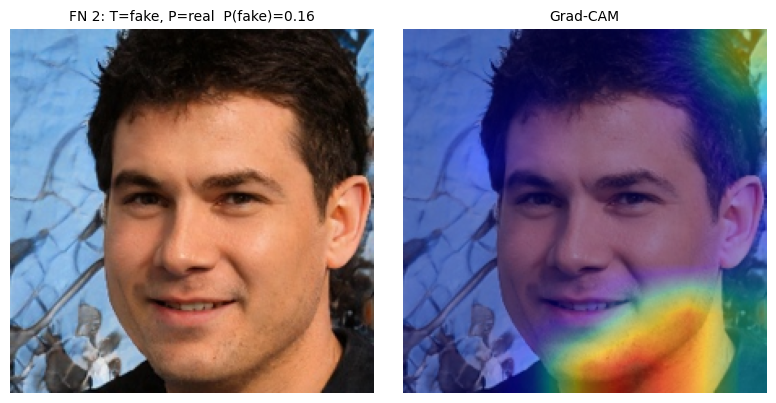

Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043165.jpg
Predicted: real, probs=[0.8396542 0.1603458]
Grad-CAM class_idx = 0 (real)
FN 3: T=fake, P=real  P(fake)=0.26


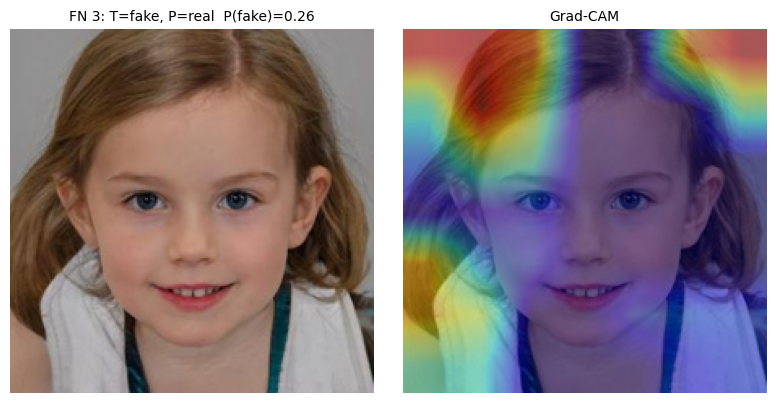

Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_050894.jpg
Predicted: real, probs=[0.73947066 0.26052928]
Grad-CAM class_idx = 0 (real)
FN 4: T=fake, P=real  P(fake)=0.28


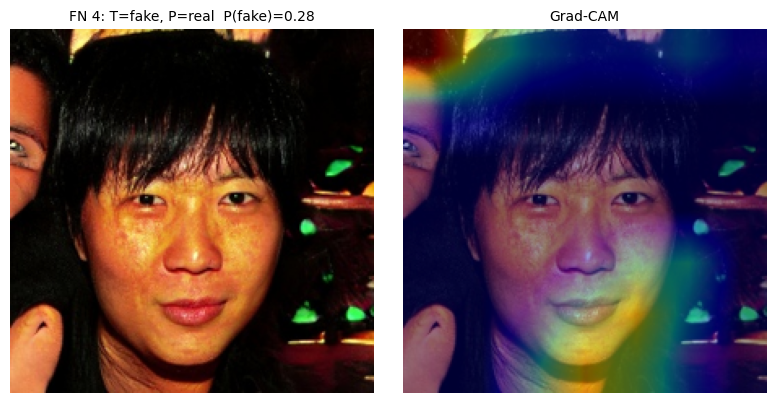

Image: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_050990.jpg
Predicted: real, probs=[0.7198204  0.28017962]
Grad-CAM class_idx = 0 (real)


In [25]:
#Make sure GradCAM use curent model
gradcam = GradCAM(model, model.layer4[-1])

for i, (path, label, pred, probs) in enumerate(fn_examples, start=1):
    title = (
        f"FN {i}: T=fake, P=real  "
        f"P(fake)={probs[1]:.2f}"
    )
    print("=" * 80)
    print(title)
    show_gradcam_for_image(
        path,
        model,
        device,
        class_idx=0,   #  "real" -> Grad-CAM
        title=title
    )


# Presentation

In [27]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
import numpy as np

# 1. Accuracy
acc = accuracy_score(y_true, y_pred)

# 2. ROC-AUC & PR-AUC 需要用 y_score（P(fake)）
y_true_scores, y_score = y_true, y_score  # 确保 y_score 已经用 collect_scores 算过

fpr, tpr, _ = roc_curve(y_true_scores, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_true_scores, y_score, pos_label=1)
pr_auc = auc(recall, precision)

# 3. F1(fake) 从 classification_report 里取
report = classification_report(
    y_true, y_pred,
    target_names=["real", "fake"],
    output_dict=True
)
f1_fake = report["fake"]["f1-score"]

print("Accuracy:", acc)
print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)
print("F1(fake):", f1_fake)

print("\nPaste these into LaTeX:\n")
print(f"\\newcommand{{\\BaselineAcc}}{{{acc:.2f}}}")
print(f"\\newcommand{{\\BaselineROCAUC}}{{{roc_auc:.2f}}}")
print(f"\\newcommand{{\\BaselinePRAUC}}{{{pr_auc:.2f}}}")
print(f"\\newcommand{{\\BaselineFoneFake}}{{{f1_fake:.2f}}}")


Accuracy: 0.852314474650992
ROC-AUC: 0.9573365301595631
PR-AUC: 0.962900609565582
F1(fake): 0.8584756204893504

Paste these into LaTeX:

\newcommand{\BaselineAcc}{0.85}
\newcommand{\BaselineROCAUC}{0.96}
\newcommand{\BaselinePRAUC}{0.96}
\newcommand{\BaselineFoneFake}{0.86}


<Figure size 400x400 with 0 Axes>

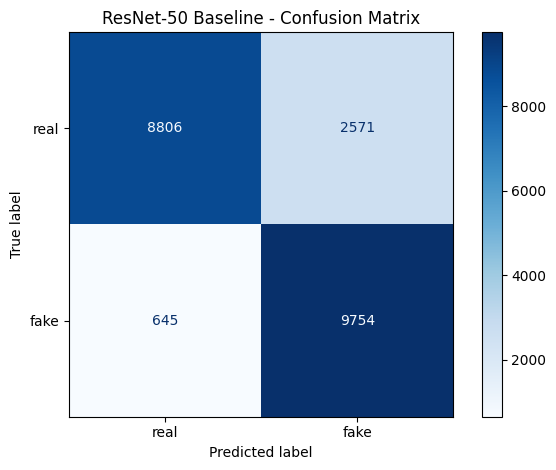

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ["real", "fake"]  # 0=real, 1=fake

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

plt.figure(figsize=(4,4))
disp.plot(values_format="d", cmap="Blues")
plt.title("ResNet-50 Baseline - Confusion Matrix")
plt.tight_layout()

# ⭐ 关键：保存成指定文件名 ⭐
plt.savefig("confusion_matrix_baseline.png", dpi=300, bbox_inches="tight")
plt.show()


# roc_curve_baseline

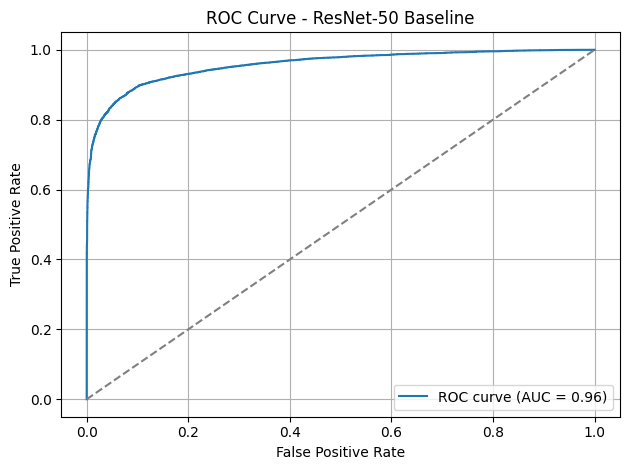

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet-50 Baseline")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("roc_curve_baseline.png", dpi=300, bbox_inches="tight")
plt.show()

# pr_curve_baseline.png

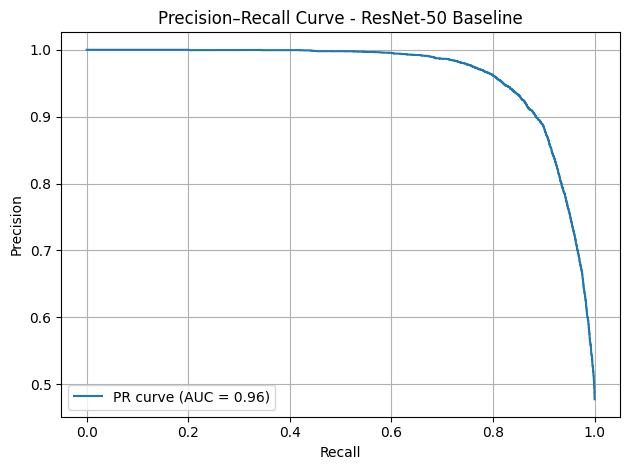

In [30]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - ResNet-50 Baseline")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("pr_curve_baseline.png", dpi=300, bbox_inches="tight")
plt.show()


# pfake_hist_baseline.png

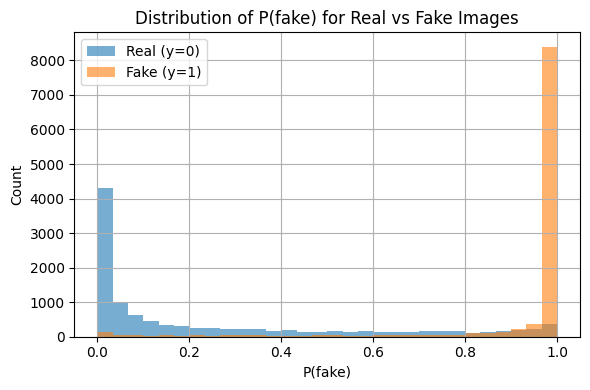

In [31]:
import numpy as np
import matplotlib.pyplot as plt

real_scores = y_score[y_true == 0]
fake_scores = y_score[y_true == 1]

plt.figure(figsize=(6,4))
plt.hist(real_scores, bins=30, alpha=0.6, label="Real (y=0)")
plt.hist(fake_scores, bins=30, alpha=0.6, label="Fake (y=1)")
plt.xlabel("P(fake)")
plt.ylabel("Count")
plt.title("Distribution of P(fake) for Real vs Fake Images")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("pfake_hist_baseline.png", dpi=300, bbox_inches="tight")
plt.show()


# Qualitative Examples: Correct Predictions

In [32]:
import torch
import numpy as np

# 0 = real, 1 = fake
class_names = ["real", "fake"]

def collect_true_positives(model, loader, device, max_real=4, max_fake=4):
    """
    从 val_loader 里收集 TP 样本：
      - TP real: T=0, P=0
      - TP fake: T=1, P=1
    返回两个列表：
      real_tps: [(img_tensor, label, pred, probs), ...]
      fake_tps: [(img_tensor, label, pred, probs), ...]
    """
    model.eval()
    real_tps = []
    fake_tps = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)   # [B,2]
            preds = probs.argmax(dim=1)            # [B]

            for i in range(imgs.size(0)):
                y_true = int(labels[i].item())
                y_pred = int(preds[i].item())
                p = probs[i].cpu().numpy()         # [P(real), P(fake)]

                # 只要 TP
                if y_true == y_pred:
                    sample = (imgs[i].cpu(), y_true, y_pred, p)

                    # TP real
                    if y_true == 0 and len(real_tps) < max_real:
                        real_tps.append(sample)

                    # TP fake
                    elif y_true == 1 and len(fake_tps) < max_fake:
                        fake_tps.append(sample)

            # 都凑满了就停
            if len(real_tps) >= max_real and len(fake_tps) >= max_fake:
                break

    return real_tps, fake_tps

real_tps, fake_tps = collect_true_positives(model, val_loader, device,
                                            max_real=4, max_fake=4)

print(f"Collected TP real: {len(real_tps)}, TP fake: {len(fake_tps)}")


Collected TP real: 4, TP fake: 4


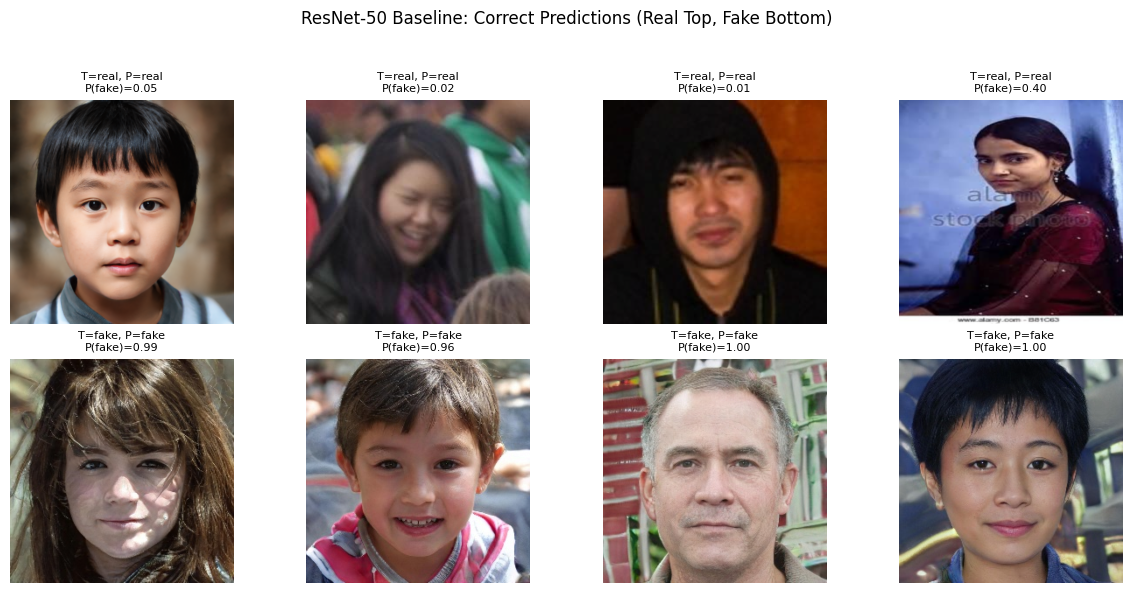

Saved qualitative TP figure to qualitative_tp_baseline.png


In [33]:
import matplotlib.pyplot as plt
import numpy as np

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    img = img_tensor.numpy()      # [3,H,W]
    img = img.transpose(1, 2, 0)  # [H,W,3]
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

def save_qualitative_tp_figure(real_tps, fake_tps, filename="qualitative_tp_baseline.png"):
    n_real = len(real_tps)
    n_fake = len(fake_tps)
    n_cols = max(n_real, n_fake)

    plt.figure(figsize=(3 * n_cols, 6))

    # Top row: real
    for idx, (img_t, label, pred, probs) in enumerate(real_tps):
        plt.subplot(2, n_cols, idx + 1)
        img = denormalize(img_t)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T=real, P=real\nP(fake)={probs[1]:.2f}", fontsize=8)

    # Bottom row: fake
    for idx, (img_t, label, pred, probs) in enumerate(fake_tps):
        plt.subplot(2, n_cols, n_cols + idx + 1)
        img = denormalize(img_t)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T=fake, P=fake\nP(fake)={probs[1]:.2f}", fontsize=8)

    plt.suptitle("ResNet-50 Baseline: Correct Predictions (Real Top, Fake Bottom)", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved qualitative TP figure to {filename}")

# 调用保存
save_qualitative_tp_figure(real_tps, fake_tps, filename="qualitative_tp_baseline.png")


# qualitative_fn_baseline.png

In [34]:
import numpy as np
from PIL import Image

class_names = ["real", "fake"]  # 0=real, 1=fake

def find_false_negatives(model, dataset, device, max_samples=4):
    """
    找到 T: fake, P: real 的样本（False Negatives）
    返回列表: (image_path, true_label, pred_label, probs)
    """
    model.eval()
    fn_examples = []

    with torch.no_grad():
        for path, label in dataset.samples:
            if label != 1:   # 只看 fake
                continue

            img = Image.open(path).convert("RGB")
            x = infer_transform(img).unsqueeze(0).to(device)

            logits = model(x)
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
            pred = int(np.argmax(probs))

            # 假图 → 判成真图：FN
            if pred == 0:  # 0 = real
                fn_examples.append((path, label, pred, probs))
                if len(fn_examples) >= max_samples:
                    break

    return fn_examples

fn_examples = find_false_negatives(model, val_dataset, device, max_samples=4)
print(f"Found {len(fn_examples)} false negatives.")
for i, (path, label, pred, probs) in enumerate(fn_examples, start=1):
    print(f"{i}. {path}")
    print(f"   T={class_names[label]}, P={class_names[pred]}, P(fake)={probs[1]:.3f}")


Found 4 false negatives.
1. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043069.jpg
   T=fake, P=real, P(fake)=0.137
2. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_043165.jpg
   T=fake, P=real, P(fake)=0.160
3. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_050894.jpg
   T=fake, P=real, P(fake)=0.261
4. /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_050990.jpg
   T=fake, P=real, P(fake)=0.280


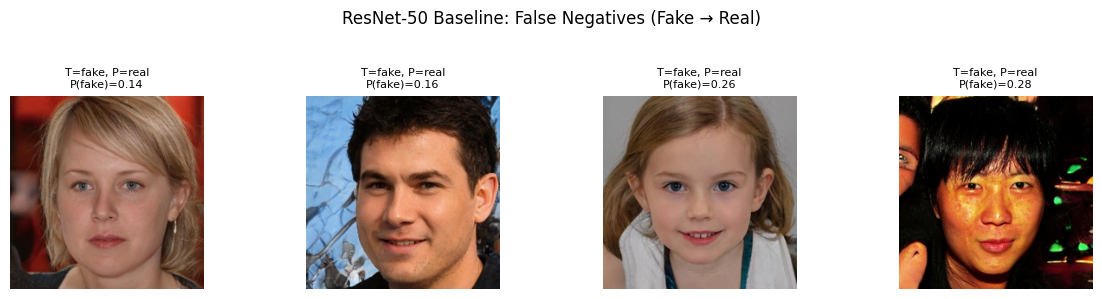

Saved FN figure to qualitative_fn_baseline.png


In [35]:
import matplotlib.pyplot as plt
from PIL import Image

def save_qualitative_fn_figure(fn_examples, filename="qualitative_fn_baseline.png"):
    """
    fn_examples: [(path, label, pred, probs), ...]，全是 T=fake, P=real
    画成 1xN 图，每张图上标 T=fake, P=real 和 P(fake)
    """
    n = len(fn_examples)
    if n == 0:
        print("No false negatives found.")
        return

    plt.figure(figsize=(3 * n, 3))

    for idx, (path, label, pred, probs) in enumerate(fn_examples, start=1):
        img = Image.open(path).convert("RGB")
        img = img.resize((224, 224))

        plt.subplot(1, n, idx)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"T=fake, P=real\nP(fake)={probs[1]:.2f}",
            fontsize=8
        )

    plt.suptitle("ResNet-50 Baseline: False Negatives (Fake → Real)", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.90])

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved FN figure to {filename}")

# 调用保存
save_qualitative_fn_figure(fn_examples, filename="qualitative_fn_baseline.png")


# gradcam_baseline_real_fake.png

In [36]:
gradcam = GradCAM(model, model.layer4[-1])
class_names = ["real", "fake"]

In [37]:
from PIL import Image
import numpy as np

def pick_tp_real_and_fake(model, dataset, device):
    """
    从 val_dataset.samples 里选：
      - 一张 T=real, P=real 的图片路径
      - 一张 T=fake, P=fake 的图片路径
    """
    model.eval()

    real_path = None
    fake_path = None

    with torch.no_grad():
        for path, label in dataset.samples:
            img = Image.open(path).convert("RGB")
            x = infer_transform(img).unsqueeze(0).to(device)

            logits = model(x)
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
            pred = int(np.argmax(probs))

            # T=real(0), P=real(0) 且 P(fake) 比较低
            if label == 0 and pred == 0 and real_path is None and probs[1] < 0.2:
                real_path = path

            # T=fake(1), P=fake(1) 且 P(fake) 比较高
            if label == 1 and pred == 1 and fake_path is None and probs[1] > 0.8:
                fake_path = path

            if real_path is not None and fake_path is not None:
                break

    print("Chosen real example:", real_path)
    print("Chosen fake example:", fake_path)
    return real_path, fake_path

real_example_path, fake_example_path = pick_tp_real_and_fake(model, val_dataset, device)


Chosen real example: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/real/real_052254.png
Chosen fake example: /root/.cache/kagglehub/datasets/ayushmandatta1/deepdetect-2025/versions/1/ddata/test/fake/fake_051541.jpg


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


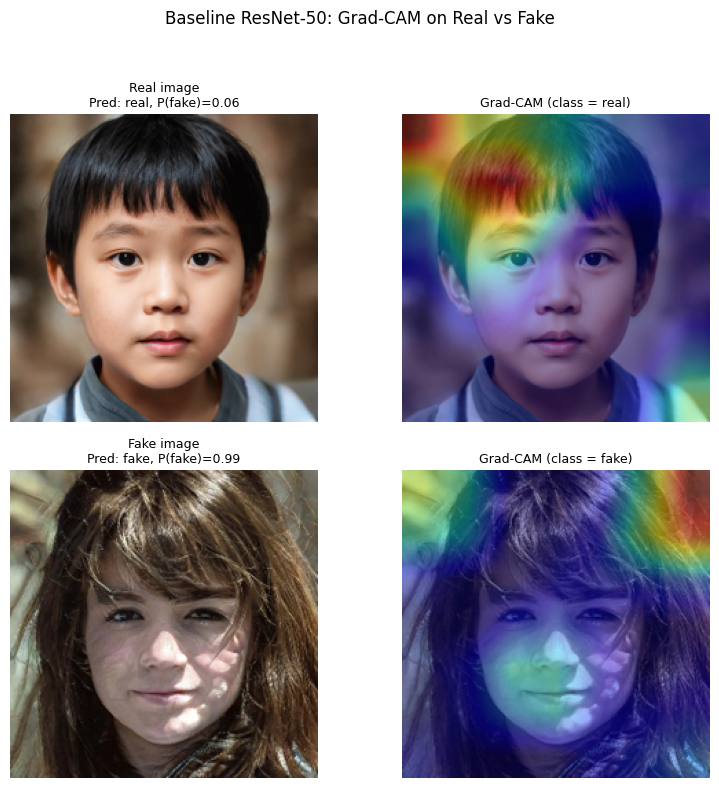

Saved Grad-CAM figure to gradcam_baseline_real_fake.png


In [38]:
import matplotlib.pyplot as plt

def compute_cam_for_path(image_path, model, device, class_idx):
    """返回原图 (224x224, [0,1]) 和对应的 CAM (224x224, [0,1])"""
    img_pil = Image.open(image_path).convert("RGB")
    img_resized = img_pil.resize((224, 224))

    x = infer_transform(img_pil).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(probs))

    cam = gradcam.generate(x, class_idx=class_idx)  # [224,224]

    img_np = np.array(img_resized) / 255.0
    return img_np, cam, probs, pred_idx

def save_gradcam_real_fake_figure(real_path, fake_path,
                                  filename="gradcam_baseline_real_fake.png"):
    """
    画成 2x2:
      [0,0] real 原图
      [0,1] real Grad-CAM (class=real)
      [1,0] fake 原图
      [1,1] fake Grad-CAM (class=fake)
    """
    # real: class_idx = 0
    real_img, real_cam, real_probs, real_pred = compute_cam_for_path(
        real_path, model, device, class_idx=0
    )

    # fake: class_idx = 1
    fake_img, fake_cam, fake_probs, fake_pred = compute_cam_for_path(
        fake_path, model, device, class_idx=1
    )

    plt.figure(figsize=(8, 8))

    # Real original
    plt.subplot(2, 2, 1)
    plt.imshow(real_img)
    plt.axis("off")
    plt.title(
        f"Real image\nPred: {class_names[real_pred]}, "
        f"P(fake)={real_probs[1]:.2f}",
        fontsize=9
    )

    # Real Grad-CAM (class=real)
    plt.subplot(2, 2, 2)
    plt.imshow(real_img)
    plt.imshow(real_cam, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title("Grad-CAM (class = real)", fontsize=9)

    # Fake original
    plt.subplot(2, 2, 3)
    plt.imshow(fake_img)
    plt.axis("off")
    plt.title(
        f"Fake image\nPred: {class_names[fake_pred]}, "
        f"P(fake)={fake_probs[1]:.2f}",
        fontsize=9
    )

    # Fake Grad-CAM (class=fake)
    plt.subplot(2, 2, 4)
    plt.imshow(fake_img)
    plt.imshow(fake_cam, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title("Grad-CAM (class = fake)", fontsize=9)

    plt.suptitle("Baseline ResNet-50: Grad-CAM on Real vs Fake", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved Grad-CAM figure to {filename}")

# 调用
save_gradcam_real_fake_figure(real_example_path, fake_example_path,
                              filename="gradcam_baseline_real_fake.png")
